# 18.8 Challenge

- Load the houseprices data from Thinkful's database.
- Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
- Now, split your data into train and test sets where 20% of the data resides in the test set.
  Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold     cross-validation to select the best hyperparameters if your models include one!
- Evaluate your best model on the test set.
- So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic    activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [91]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

---

## Data Cleaning

In [92]:
#dataset summary
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [93]:
#preview the dataset
pd.options.display.max_columns = None
houses_df.describe(include='all')

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.0

In [94]:
#missing value evaluation
total_missing = houses_df.isnull().sum().sort_values(ascending=False)
percent_missing = (houses_df.isnull().sum()/houses_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


In [95]:
#electrical variable
houses_df.electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64

In [96]:
#garage type variable
houses_df.garagetype.value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: garagetype, dtype: int64

#### Data Cleaning Summary

Looking at our missing values above, we can decide right away that poolqc, miscfeature, alley and fence can be dropped from the dataset as they're missing over 80% of their values. 

As can be seen, there are many missing values in columns related to garages and basements. Since not all houses have garages or basements, we are going to assume that these missing values are because of a lack of basement or garage. Also, if you look at the values of missing data in these columns, they are all the same. The best way to handle this would be to create a new category for houses not having a basement or garage. The same can be said about fireplacequ, not all houses have fireplaces so we will assume missing values represent no fireplace.

Since lot frontage is a float type and is missing less than 20% of its data we can interpolate the missing values for this column. 

For masvnarea, since it is missing less than 1% of its values we can fill in the missing values as 0. For masvnrtype, since it is an object, we can use 'none' for now. 

In electrical, we're only missing one data point and with most of the data being of 'SBrker' type, we can fill in this missing value accordingly. 



In [97]:
#drop above mentioned columns
houses_df = houses_df.drop(['poolqc', 'miscfeature', 'alley', 'fence'], axis=1)

In [98]:
#interpolate lot frontage data
houses_df['lotfrontage'] = houses_df.lotfrontage.interpolate()

In [99]:
#create new 'none' category and fill in electrical and masvnarea missing values
houses_df['fireplacequ'].fillna('None', inplace=True)
houses_df['garagecond'].fillna('None', inplace=True)
houses_df['garagetype'].fillna('None', inplace=True)
houses_df['garageyrblt'].fillna('None', inplace=True)
houses_df['garagefinish'].fillna('None', inplace=True)
houses_df['garagequal'].fillna('None', inplace=True)
houses_df['bsmtexposure'].fillna('None', inplace=True)
houses_df['bsmtfintype2'].fillna('None', inplace=True)
houses_df['bsmtfintype1'].fillna('None', inplace=True)
houses_df['bsmtcond'].fillna('None', inplace=True)
houses_df['bsmtqual'].fillna('None', inplace=True)
houses_df['masvnrarea'].fillna(0.0, inplace=True)
houses_df['masvnrtype'].fillna('None', inplace=True)
houses_df['electrical'].fillna('SBrkr', inplace=True)

In [100]:
#verify missing data has been handled
#houses_df.info()

---

## Feature Selection

In [101]:
#preview the top correlated variables to saleprice
np.abs(houses_df.corr().loc["saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.472614
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
lotfrontage      0.310557
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
id               0.021917
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

According to the list above, 'overallqual', 'grlivarea', 'garagecars', 'garagearea', and 'totalbsmtsf' are the top 5 strongest corrleated variables with saleprice. Let's take a closer look at these variables to see if they are correlated with any other variables within our dataset.

In [13]:
houses_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.007971,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.351725,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.007971,-0.351725,1.000000,0.278073,0.222695,-0.050313,0.110855,0.074601,0.165730,0.199379,0.044501,0.116092,0.340576,0.390534,0.060183,0.049191,0.341857,0.084790,-0.020968,0.163589,0.048792,0.222606,-0.011293,0.299399,0.219611,0.256379,0.305984,0.066132,0.116803,-0.005302,0.053757,0.038183,0.162122,-0.012093,0.014167,0.009811,0.310557
lotarea,-0.033226,-0.139781,0.278073,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.222695,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.050313,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.110855,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.074601,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.051071,0.023573,0.165730,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,0.173800,-0.068628,0.388052,0.083010,0.027403,0.272999,0.199108,0.102775,-0.038450,0.279568,0.247015,0.361945,0.370884,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
bsmtfinsf1,-0.005024,-0.069836,0.199379,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


Looking at our correlation matrix, some of our top correlated variables with saleprice have strong correlation with one another. 'grlivarea' is strongly related with 'totrmsabvgrd' (0.825); 'garagecars' with 'garagearea' (0.882); 'totalbsmtsf' with 'firstflsf' (0.819). 

For this exercise, totalbsmtsf and firstflrsf will be averaged to create a new variable. An interaction term will be made between garagearea and garagecars called garage. We will use grlivarea and ignore totrmsabvgrd.

In [102]:
#average out the total basement sq footage and first floor square footage to create a new variable
#create an interaction term using garage area and garage cars variables
houses_df['avgsf'] = houses_df[['totalbsmtsf', 'firstflrsf']].mean(axis=1)
houses_df['garage'] = houses_df.garagearea * houses_df.garagecars
#houses_df

Test for outliers within our top correlated variables

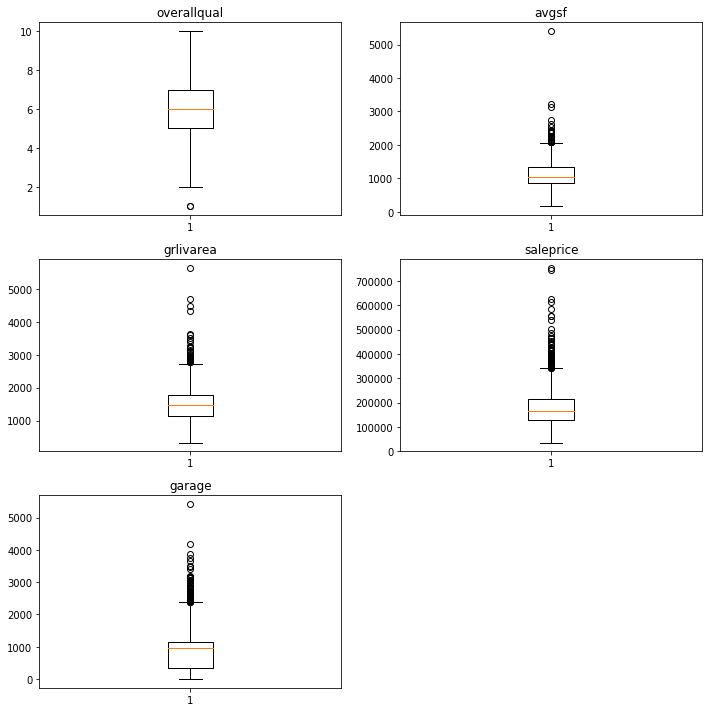

In [103]:
#search for outliers within the data

plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.boxplot(houses_df['overallqual'])
plt.title('overallqual')

plt.subplot(3,2,2)
plt.boxplot(houses_df['avgsf'])
plt.title('avgsf')

plt.subplot(3,2,3)
plt.boxplot(houses_df['grlivarea'])
plt.title('grlivarea')

plt.subplot(3,2,4)
plt.boxplot(houses_df['saleprice'])
plt.title('saleprice')

plt.subplot(3,2,5)
plt.boxplot(houses_df['garage'])
plt.title('garage')

plt.tight_layout()
plt.show()

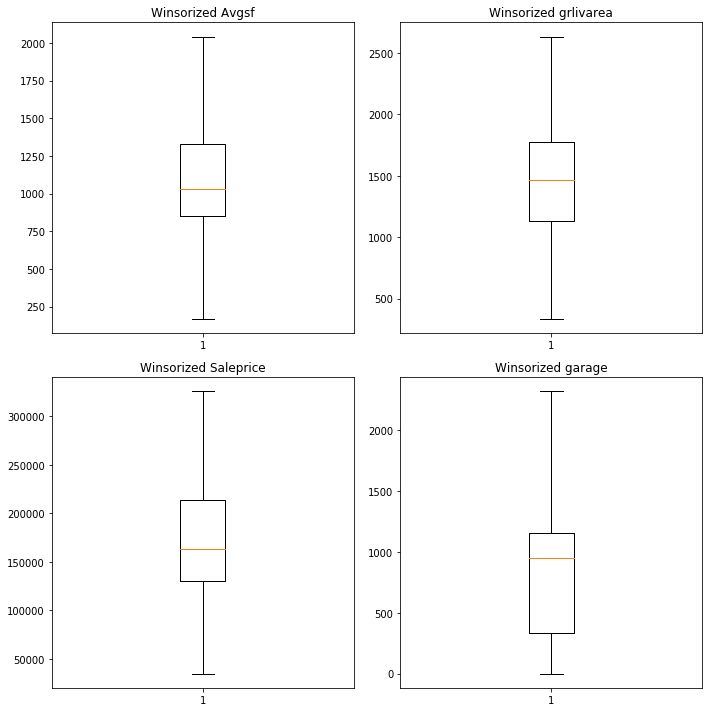

In [104]:
#winsorize the outliers

houses_df['winsorized_avgsf'] = winsorize(houses_df['avgsf'], (0, 0.02))
houses_df['winsorized_grlivarea'] = winsorize(houses_df['grlivarea'], (0, 0.03))
houses_df['winsorized_saleprice'] = winsorize(houses_df['saleprice'], (0, 0.05))
houses_df['winsorized_garage'] = winsorize(houses_df['garage'], (0, 0.08))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.boxplot(houses_df['winsorized_avgsf'])
plt.title('Winsorized Avgsf')

plt.subplot(2,2,2)
plt.boxplot(houses_df['winsorized_grlivarea'])
plt.title('Winsorized grlivarea')

plt.subplot(2,2,3)
plt.boxplot(houses_df['winsorized_saleprice'])
plt.title('Winsorized Saleprice')

plt.subplot(2,2,4)
plt.boxplot(houses_df['winsorized_garage'])
plt.title('Winsorized garage')

plt.tight_layout()
plt.show()

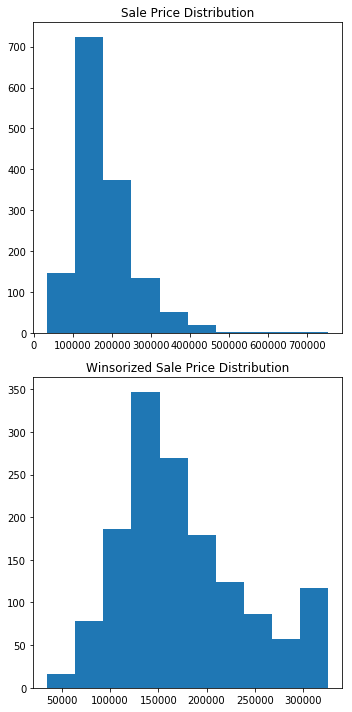

Jarque-Bera test statistics is 3438.8721241220583 and p value is 0.0
Normality test statistics is 610.8359109472653 and p value is 2.283848353787728e-133
Jarque-Bera test statistics is 127.16879626197489 and p value is 0.0
Normality test statistics is 104.86701931527972 and p value is 1.692061285416133e-23


In [107]:
#plot target variable distribution

plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.hist(houses_df['saleprice'])
plt.title('Sale Price Distribution')

plt.subplot(2,1,2)
plt.hist(houses_df['winsorized_saleprice'])
plt.title('Winsorized Sale Price Distribution')

plt.tight_layout()
plt.show()

#test for normality
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(houses_df['saleprice'])
norm_stats = normaltest(houses_df['saleprice'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(houses_df['winsorized_saleprice'])
norm_stats = normaltest(houses_df['winsorized_saleprice'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

In [146]:
#normalize the data 

houses_df['norm_win_avgsf'] = normalize(np.array(houses_df['winsorized_avgsf']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_win_grlivarea'] = normalize(np.array(houses_df['winsorized_grlivarea']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_overallqual'] = normalize(np.array(houses_df['overallqual']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_garagecars'] = normalize(np.array(houses_df['garagecars']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_fullbath'] = normalize(np.array(houses_df['fullbath']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_win_saleprice'] = normalize(np.array(houses_df['winsorized_saleprice']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_win_garage'] = normalize(np.array(houses_df['winsorized_garage']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_mszoningFV'] = normalize(np.array(houses_df['mszoning_FV']).reshape(1,-1)).reshape(-1,1)
houses_df['norm_mszoningRL'] = normalize(np.array(houses_df['mszoning_RL']).reshape(1,-1)).reshape(-1,1)


houses_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,Month,Year,saletype,salecondition,saleprice,avgsf,garage,winsorized_avgsf,winsorized_grlivarea,winsorized_saleprice,winsorized_garage,norm_win_avgsf,norm_win_grlivarea,norm_overallqual,norm_garagecars,norm_fullbath,norm_win_saleprice,norm_win_garage,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,norm_mszoningFV,norm_mszoningRL
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,856.0,1096,856.0,1710,208500,1096,0.019311,0.028433,0.029293,0.027282,0.031548,0.028954,0.025225,0,0,1,0,0.0,0.029476
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,1262.0,920,1262.0,1262,181500,920,0.028471,0.020984,0.025108,0.027282,0.031548,0.025204,0.021174,0,0,1,0,0.0,0.029476
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,920.0,1216,920.0,1786,223500,1216,0.020755,0.029697,0.029293,0.027282,0.031548,0.031037,0.027987,0,0,1,0,0.0,0.029476
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,858.5,1926,858.5,1717,140000,1926,0.019368,0.028549,0.029293,0.040923,0.015774,0.019441,0.044328,0,0,1,0,0.0,0.029476
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,1145.0,2508,1145.0,2198,250000,2322,0.025831,0.036547,0.033477,0.040923,0.031548,0.034717,0.053442,0,0,1,0,0.0,0.029476


Jarque-Bera test statistics is 127.16879626197432 and p value is 0.0
Normality test statistics is 104.86701931527945 and p value is 1.6920612854163662e-23


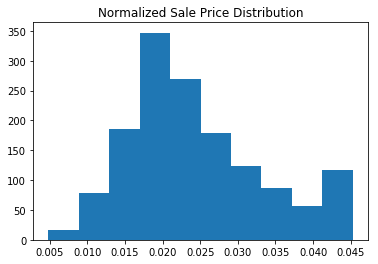

In [108]:
plt.hist(houses_df['norm_win_saleprice'])
plt.title('Normalized Sale Price Distribution')

jb_stats = jarque_bera(houses_df['norm_win_saleprice'])
norm_stats = normaltest(houses_df['norm_win_saleprice'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

In [109]:
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
cat_column_names = list(pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True).columns)

houses_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,avgsf,garage,winsorized_avgsf,winsorized_grlivarea,winsorized_saleprice,winsorized_garage,norm_win_avgsf,norm_win_grlivarea,norm_overallqual,norm_garagecars,norm_fullbath,norm_win_saleprice,norm_win_garage,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,856.0,1096,856.0,1710,208500,1096,0.019311,0.028433,0.029293,0.027282,0.031548,0.028954,0.025225,0,0,1,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,1262.0,920,1262.0,1262,181500,920,0.028471,0.020984,0.025108,0.027282,0.031548,0.025204,0.021174,0,0,1,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,920.0,1216,920.0,1786,223500,1216,0.020755,0.029697,0.029293,0.027282,0.031548,0.031037,0.027987,0,0,1,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,858.5,1926,858.5,1717,140000,1926,0.019368,0.028549,0.029293,0.040923,0.015774,0.019441,0.044328,0,0,1,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,1145.0,2508,1145.0,2198,250000,2322,0.025831,0.036547,0.033477,0.040923,0.031548,0.034717,0.053442,0,0,1,0


---

## Build the Models

### Linear Regression Model with Training Set

In [147]:
Y = houses_df['norm_win_saleprice']
X = houses_df[['norm_win_avgsf', 'norm_win_grlivarea', 'norm_overallqual', 'norm_win_garage', 'norm_mszoningFV', 'norm_mszoningRL']]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [0.19509106 0.32857986 0.63593547 0.12026896 0.03072221 0.09647837]

Intercept: 
 -0.009782954465427506


In [148]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     norm_win_saleprice   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:44:44   Log-Likelihood:                 4892.8
No. Observations:                1168   AIC:                            -9772.
Df Residuals:                    1161   BIC:                            -9736.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0100      0.001    -17.581      0.000      -0.011      -0.009
norm_win_avgsf         0.1865      0.017     10.769      0.000       0.153       0.221
norm_win_grlivarea     0.3257      0.018     18.160      0.000       0.291       0.361
norm_overallqual       0.6456      0.028     23.280      0.000       0.591       0.700
norm_win_garage        0.1237      0.010     12.154      0.000       0.104       0.144
norm_mszoningFV        0.0310      0.005      6.491      0.000       0.022       0.040
norm_mszoningRL        0.1012      0.010      9.687      0.000       0.081       0.122
==============================================================================
Omnibus:                      211.456   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1422.073
Skew:                          -0.652   Prob(JB):                    1.59e-309
Kurtosis:                       8.246   Cond. No.                         272.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [149]:
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [150]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8380582769444839
-----Test set statistics-----
R-squared of the model in test set is: 0.8240822168032855
Mean absolute error of the prediction is: 0.0028301267857486997
Mean squared error of the prediction is: 1.455044667701741e-05
Root mean squared error of the prediction is: 0.0038145047748059523
Mean absolute percentage error of the prediction is: 13.494876121743605


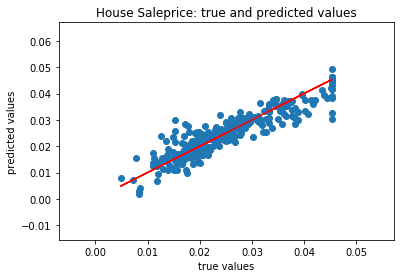

In [151]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Saleprice: true and predicted values")
plt.show()

---

### Lasso with Cross Validation

In [152]:
lasso = linear_model.LassoCV()
lasso.fit(X, Y)

print('\nCoefficients: \n', lasso.coef_)
print('\nIntercept: \n', lasso.intercept_)


Coefficients: 
 [0.         0.19454151 0.32805313 0.6332441  0.12093895 0.0305098
 0.095823  ]

Intercept: 
 -0.009685642657141107


In [153]:
alpha = [np.power(10.0,p) for p in np.arange(-5,10,1)]

In [154]:
lasso_cv = LassoCV(alphas=alpha, cv=10)

lasso_cv.fit(X_train, y_train)

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.7867893458043878
-----Test set statistics-----
R-squared of the model in test set is: 0.777120437891999
Mean absolute error of the prediction is: 0.0030818915367775176
Mean squared error of the prediction is: 1.8434731980581403e-05
Root mean squared error of the prediction is: 0.004293568676588439
Mean absolute percentage error of the prediction is: 14.091306426755711


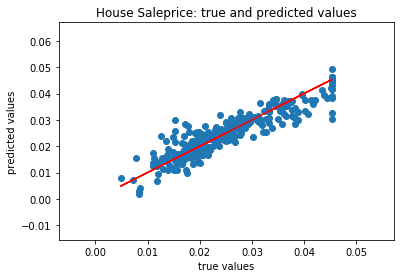

In [155]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Saleprice: true and predicted values")
plt.show()

---

### Ridge Regression with Cross Validation

In [156]:
ridge = linear_model.RidgeCV()
ridge.fit(X, Y)

print('\nCoefficients: \n', ridge.coef_)
print('\nIntercept: \n', ridge.intercept_)


Coefficients: 
 [0.         0.16614568 0.21649415 0.20236809 0.20301773 0.03776123
 0.0870175 ]

Intercept: 
 0.003178376301867618


In [157]:
ridge_cv = RidgeCV(alphas=alpha, cv=10)

ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8380564982151302
-----Test set statistics-----
R-squared of the model in test set is: 0.8241268628226774
Mean absolute error of the prediction is: 0.002828372854177405
Mean squared error of the prediction is: 1.4546753931959472e-05
Root mean squared error of the prediction is: 0.003814020704186
Mean absolute percentage error of the prediction is: 13.482015651172796


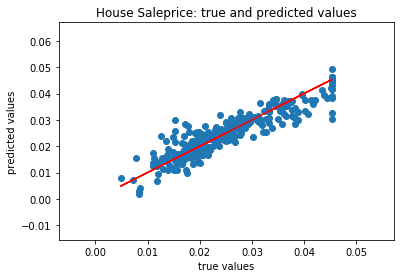

In [158]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Saleprice: true and predicted values")
plt.show()

---

### ElasticNet with Cross Validation

In [159]:
elastic = linear_model.ElasticNetCV()
elastic.fit(X, Y)

print('\nCoefficients: \n', elastic.coef_)
print('\nIntercept: \n', elastic.intercept_)


Coefficients: 
 [0.         0.19482736 0.32820583 0.63016116 0.12150493 0.03060109
 0.09583593]

Intercept: 
 -0.00963101311635444


In [160]:
elasticnet_cv = ElasticNetCV(alphas=alpha, cv=10)

elasticnet_cv.fit(X_train, y_train)

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.8148443608938436
-----Test set statistics-----
R-squared of the model in test set is: 0.8037486341232897
Mean absolute error of the prediction is: 0.00290543217041479
Mean squared error of the prediction is: 1.6232270453793658e-05
Root mean squared error of the prediction is: 0.004028929194437854
Mean absolute percentage error of the prediction is: 13.364001672954434


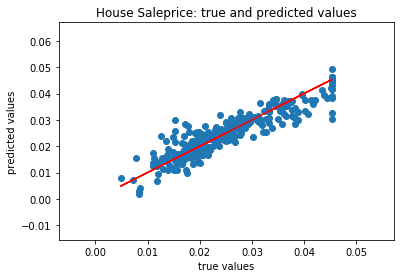

In [161]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Saleprice: true and predicted values")
plt.show()

The Ridge Regression model seems to perform best as seen above. It shows the highest R squared values while maintaining the lowest difference in training vs test sets. It also has the best evaluation metrics among the models but not by much when compared to linear regression. 

---

When researching economic factors that impact house sale prices, GDP was a common variable. Below I have uploaded a GDP dataset and inputted the variable into the model. 

## External Variables

In [162]:
houses_df.rename(columns={'yrsold': 'Year', 'mosold': 'Month'}, inplace=True)

In [163]:
gdp = pd.read_csv(r'C:\Users\kylem\Desktop\Thinkful Data Science Projects\year_GDP_csv.csv')

In [164]:
gdp.rename(columns={'date': 'Year'}, inplace=True)
gdp.head()

,Year,level-current,level-chained,change-current,change-chained
0,1930,92.2,966.7,-16.0,-6.4
1,1931,77.4,904.8,-23.1,-12.9
2,1932,59.5,788.2,-4.0,-1.3
3,1933,57.2,778.3,16.9,10.8
4,1934,66.8,862.2,11.1,8.9


In [165]:
houses_df2 = pd.merge(houses_df, gdp, on=['Year'])

Text(0.5,1,'GDP')

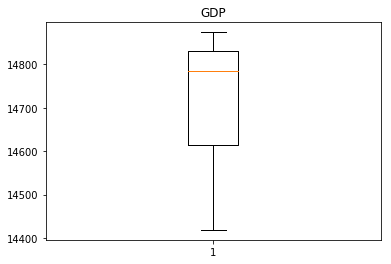

In [166]:
plt.boxplot(houses_df2['level-chained'])
plt.title('GDP')

In [167]:
houses_df2['norm_level_chained'] = normalize(np.array(houses_df2['level-chained']).reshape(1,-1)).reshape(-1,1)
houses_df2['norm_current_level'] = normalize(np.array(houses_df2['level-current']).reshape(1,-1)).reshape(-1,1)

In [168]:
Y = houses_df2['norm_win_saleprice']
X = houses_df2[['norm_win_avgsf', 'norm_win_grlivarea', 'norm_overallqual', 'norm_win_garage', 'norm_mszoningFV', 'norm_mszoningRL' , 'norm_level_chained']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     norm_win_saleprice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     830.1
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:46:03   Log-Likelihood:                 4881.2
No. Observations:                1168   AIC:                            -9746.
Df Residuals:                    1160   BIC:                            -9706.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0216      0.009     -2.356      0.019      -0.040      -0.004
norm_win_avgsf         0.1942      0.018     11.011      0.000       0.160       0.229
norm_win_grlivarea     0.2989      0.018     16.542      0.000       0.263       0.334
norm_overallqual       0.6572      0.027     23.958      0.000       0.603       0.711
norm_win_garage        0.1189      0.010     11.613      0.000       0.099       0.139
norm_mszoningFV        0.0305      0.005      6.258      0.000       0.021       0.040
norm_mszoningRL        0.0945      0.011      8.896      0.000       0.074       0.115
norm_level_chained     0.4594      0.349      1.316      0.188      -0.225       1.144
==============================================================================
Omnibus:                      219.481   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1232.542
Skew:                          -0.742   Prob(JB):                    2.27e-268
Kurtosis:                       7.809   Cond. No.                     3.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
ridge_cv = RidgeCV(alphas=alpha, cv=10)

ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8335261807383494
-----Test set statistics-----
R-squared of the model in test set is: 0.8410771200878977
Mean absolute error of the prediction is: 0.002731306320197106
Mean squared error of the prediction is: 1.3550776504756471e-05
Root mean squared error of the prediction is: 0.003681137936121991
Mean absolute percentage error of the prediction is: 11.996773752107103


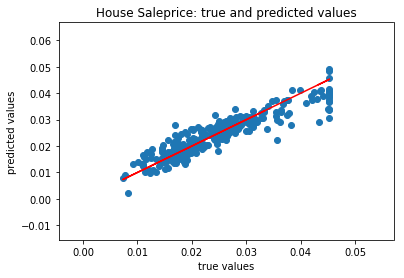

In [170]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House Saleprice: true and predicted values")
plt.show()

According to our results above, we can determine that the feature 'level-chained' is just barely stastistically insignificant in our model. 'Level-chained' is GDP adjusted for inflation. It would make sense that the growth of the economy would have an effect on house sale prices but the model is telling us that the variable is insignificant statistically.  

Interestingly, our evaluation metrics improve with the addition of the GDP variable. Also, when using RidgeCV, our test set performs slightly better than the training set. 